In [1]:
# Initialize SparkContext and SparkSession
import findspark, os
findspark.init('/home/hadoop/spark')
import pyspark
from pyspark.sql import SparkSession
conf = pyspark.SparkConf().setMaster("yarn").setAppName("Jupyter PySpark Test")
sc = pyspark.SparkContext(conf = conf)
spark = SparkSession(sc)

In [2]:
# Read title.basics.tsv into Spark dataframe
imdb_title_basics_dataframe = spark.read.format('csv').options(\
    header='true', delimiter='\t', nullValue='null', inferschema='true')\
    .load('/user/hadoop/imdb/title_basics/title.basics.tsv')

In [3]:
imdb_title_basics_dataframe.printSchema() # Print Schema of title_basics dataframe 

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: integer (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)



In [4]:
imdb_title_basics_dataframe.show(5) # Show first 5 rows of title_basics dataframe 

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             4|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            \N|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|     1893|     \N|             1|        Comedy

In [5]:
imdb_title_basics_dataframe.count() # show number of rows within title_basics dataframe 

6262637

In [6]:
# Get column titleTypes values with counts and ordered descending
from pyspark.sql.functions import desc
imdb_title_basics_dataframe.groupBy("titleType").count().orderBy(desc("count")).show()

+------------+-------+
|   titleType|  count|
+------------+-------+
|   tvEpisode|4392190|
|       short| 707983|
|       movie| 533869|
|       video| 245253|
|    tvSeries| 173337|
|     tvMovie| 120824|
|tvMiniSeries|  28114|
|   tvSpecial|  25479|
|   videoGame|  24322|
|     tvShort|  11266|
+------------+-------+



In [7]:
# Calculate average Movie length in minutes
from pyspark.sql.functions import avg
imdb_title_basics_dataframe.filter(imdb_title_basics_dataframe['titleType']=='movie')\
    .agg(avg('runtimeMinutes')).show() 

+-------------------+
|avg(runtimeMinutes)|
+-------------------+
|  88.34293031750659|
+-------------------+



In [8]:
# Read title.ratings.tsv into Spark dataframe
imdb_title_ratings_dataframe = spark.read.format('csv').options(\
    header='true', delimiter='\t', nullValue='null', inferschema='true')\
    .load('/user/hadoop/imdb/title_ratings/title.ratings.tsv')

In [9]:
imdb_title_ratings_dataframe.printSchema() # Print Schema of title_ratings dataframe 

root
 |-- tconst: string (nullable = true)
 |-- averageRating: double (nullable = true)
 |-- numVotes: integer (nullable = true)



In [10]:
imdb_title_ratings_dataframe.show(5) # Show first 5 rows of title_ratings dataframe 

+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt0000001|          5.6|    1543|
|tt0000002|          6.1|     186|
|tt0000003|          6.5|    1201|
|tt0000004|          6.2|     114|
|tt0000005|          6.1|    1921|
+---------+-------------+--------+
only showing top 5 rows



In [11]:
# JOIN Data Frames
title_basics_and_ratings_df = imdb_title_basics_dataframe.join(imdb_title_ratings_dataframe, \
                            imdb_title_basics_dataframe.tconst == imdb_title_ratings_dataframe.tconst)

In [12]:
top_tvseries=title_basics_and_ratings_df.filter(title_basics_and_ratings_df['titleType']=='tvSeries')\
                            .filter(title_basics_and_ratings_df['numVotes'] > 200000)\
                            .orderBy(desc('averageRating'))\
                            .select('originalTitle', 'startYear', 'endYear', 'averageRating', 'numVotes')
top_tvseries.show(5)

+--------------------+---------+-------+-------------+--------+
|       originalTitle|startYear|endYear|averageRating|numVotes|
+--------------------+---------+-------+-------------+--------+
|        Breaking Bad|     2008|   2013|          9.5| 1271805|
|     Game of Thrones|     2011|   2019|          9.4| 1598911|
|      Rick and Morty|     2013|     \N|          9.3|  296206|
|            The Wire|     2002|   2008|          9.3|  254371|
|Avatar: The Last ...|     2005|   2008|          9.2|  200077|
+--------------------+---------+-------+-------------+--------+
only showing top 5 rows



In [14]:
top_tvseries.write.format('parquet')\
                    .partitionBy('startYear')\
                    .mode('overwrite')\
                    .save('/user/hadoop/imdb/top_tvseries')

In [15]:
good_movies_df = title_basics_and_ratings_df.filter(title_basics_and_ratings_df['titleType']=='movie')\
                            .filter(title_basics_and_ratings_df['numVotes'] > 200000)\
                            .filter(title_basics_and_ratings_df['startYear'] > 1990)\
                            .groupBy('startYear')\
                            .count()\
                            .orderBy('startYear')
good_movies_df.show(5)

+---------+-----+
|startYear|count|
+---------+-----+
|     1991|    4|
|     1992|    8|
|     1993|    8|
|     1994|   13|
|     1995|   14|
+---------+-----+
only showing top 5 rows



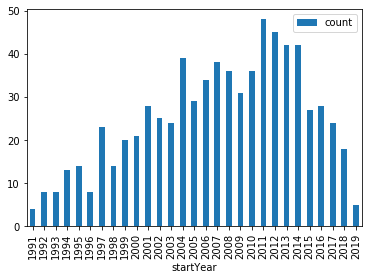

In [19]:
import matplotlib.pyplot as plt
import pandas
pandas_dataframe = good_movies_df.select('startYear', 'count').toPandas()
pandas_dataframe.plot.bar(x='startYear', y='count')

In [17]:
title_basics_and_ratings_df.select('originalTitle', 'titleType', 'startYear', \
                                   'endYear', 'numVotes', 'averageRating')\
                            .write.saveAsTable('movies_and_ratings')

In [18]:
result_df = spark.sql("""SELECT originalTitle, averageRating FROM movies_and_ratings WHERE 
                        numVotes > 200000 AND titleType= 'movie' AND averageRating > 8.5 AND startYear > 2010 
                        ORDER BY averageRating DESC LIMIT 10"""
                     ).show(10)

+-------------+-------------+
|originalTitle|averageRating|
+-------------+-------------+
|        Joker|          8.9|
| Interstellar|          8.6|
+-------------+-------------+

